In [1]:
import os, sys
import pandas as pd
import numpy as np
import random

from utils.method import read_bic_table, make_consensus_biclusters2, zscore, write_bic_table
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
in_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
out_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
dataset = 'TCGA-BRCA'
exprs_file = "data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv"

#in_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
#out_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
#dataset = 'METABRIC'
#exprs_file = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"

suffix  = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv" 

In [3]:
exprs= pd.read_csv(exprs_file,sep = "\t",index_col=0)

In [4]:
n_runs = 5
cseed = 42 # seed for consensus of 5 runs
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [670487, 116739, 26225, 777572, 288389]


In [5]:
# reading biclusters detected in independent runs
biclustering_results = []
for seed in seeds:
    biclusters = read_bic_table(in_dir+dataset+".seed="+str(seed)+suffix)
    print("seed %s n biclusters: %s"%(seed,biclusters.shape[0]))
    # reindexing
    biclusters.index = ["seed="+str(seed)+"_"+str(x) for x in biclusters.index.values ]
    biclustering_results.append(biclusters)


seed 670487 n biclusters: 168
seed 116739 n biclusters: 197
seed 26225 n biclusters: 150
seed 777572 n biclusters: 134
seed 288389 n biclusters: 210


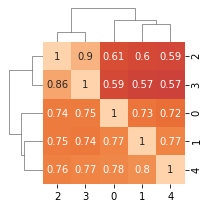

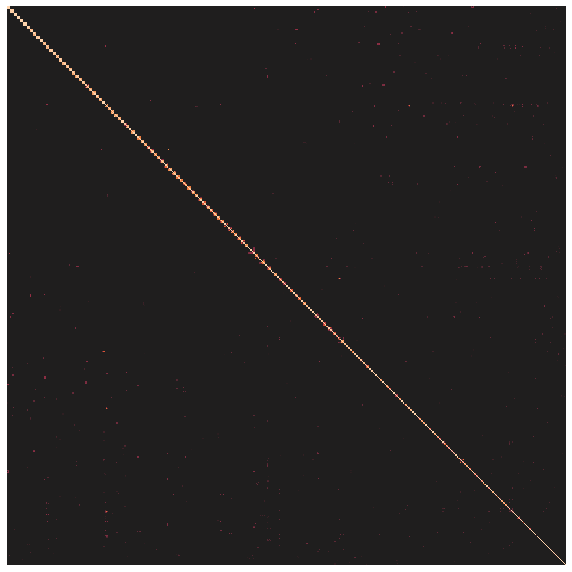

46 s for similarity matrix
	Running Louvain ...
	curve type: increasing


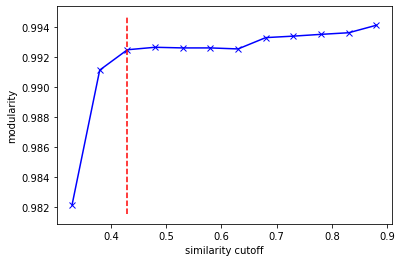

	Louvain runtime: modules detected in 0.70 s.
	modules: 210, not clustered features 86 
		similarity cutoff: 0.43 modularity: 0.992
all consensus biclusters: 297
detected 2+ times:209
31 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times
0,2.931461,2,38,"{CTAG1A, CTAG1B}","{TCGA-D8-A1XQ-01, TCGA-AO-A128-01, TCGA-A2-A4S...","{CTAG1A, CTAG1B}",{},"{3385, 3386}","{1038, 529, 917, 279, 1047, 797, 289, 291, 48,...",UP,3
1,2.857572,331,195,"{L3MBTL4, REEP1, GJB3, PGBD5, AMY1A, CCKBR, AB...","{TCGA-AC-A62X-01, TCGA-S3-AA15-01, TCGA-B6-A40...","{L3MBTL4, FOXG1, PRDM13, TRIML2, TMCC2, TTLL4,...","{REEP1, C9orf152, AGR2, HOXB2, LIMA1, GATA2, P...","{12288, 16397, 14358, 16411, 30, 51, 4148, 824...","{1024, 514, 1018, 1030, 519, 8, 1035, 524, 103...",BOTH,10
2,2.562175,115,13,"{FSHB, KRTAP11-1, C9orf57, OR5C1, POTEB, PRPS1...","{TCGA-A7-A13D-01, TCGA-A7-A0DB-01, TCGA-A7-A26...","{FSHB, KRTAP11-1, C9orf57, OR5C1, POTEB, PRPS1...",{},"{8194, 10251, 13836, 13838, 15375, 2063, 13841...","{130, 131, 132, 133, 262, 135, 137, 138, 268, ...",UP,6
3,2.508195,36,44,"{AADACL2, SERPINB11, FOXE1, CCDC190, CYP2C18, ...","{TCGA-A2-A3Y0-01, TCGA-AO-A0JD-01, TCGA-B6-A0R...","{AADACL2, SERPINB11, FOXE1, CCDC190, CYP2C18, ...",{},"{5888, 5250, 3971, 9, 7567, 13078, 2849, 14114...","{128, 1024, 515, 132, 518, 519, 264, 138, 523,...",UP,8
4,2.484135,4,28,"{TRIM49, TRIM49C, PRR20A, TRIM49D2}","{TCGA-EW-A1J6-01, TCGA-B6-A402-01, TCGA-BH-A0B...","{TRIM49, TRIM49C, PRR20A, TRIM49D2}",{},"{15577, 15578, 11558, 15575}","{132, 133, 390, 774, 522, 141, 19, 915, 917, 5...",UP,3
...,...,...,...,...,...,...,...,...,...,...,...
204,1.202805,2,308,"{CGB5, LHB}","{TCGA-B6-A402-01, TCGA-A7-A6VV-01, TCGA-GM-A3X...","{CGB5, LHB}",{},"{7787, 2676}","{1, 22, 23, 30, 34, 37, 38, 39, 40, 44, 45, 46...",UP,2
205,1.176224,3,503,"{CLDN15, GP9, EGFL7}","{TCGA-EW-A1J6-01, TCGA-AR-A24O-01, TCGA-A2-A3X...","{CLDN15, EGFL7, GP9}",{},"{5823, 4314, 2847}","{0, 1, 2, 3, 5, 6, 7, 9, 11, 15, 22, 26, 28, 3...",UP,3
206,1.141976,2,212,"{NPHS1, PRODH2}","{TCGA-S3-AA17-01, TCGA-A7-A3J0-01, TCGA-S3-AA1...","{NPHS1, PRODH2}",{},"{11514, 9782}","{0, 2, 1028, 517, 1031, 1033, 522, 523, 12, 52...",UP,2
207,1.080423,2,210,"{PPP1R1C, NEUROD1}","{TCGA-AQ-A0Y5-01, TCGA-V7-A7HQ-01, TCGA-A1-A0S...","{NEUROD1, PPP1R1C}",{},"{11340, 9550}","{1024, 1, 2, 9, 522, 526, 1039, 16, 1040, 531,...",UP,2


In [6]:
consensus_biclusters=make_consensus_biclusters2(biclustering_results, zscore(exprs), 
                                                      method = "kmeans", min_n_genes=2,
                                                      similarity = "samples",
                                                      seed = cseed,
                                                      verbose = True,
                                                      plot = True, 
                                                      figsize=(10, 10),
                                                      labels=False,
                                                      colorbar_off=True)
consensus_biclusters

In [7]:
outfname = out_dir+"/"+dataset+".consensus_seed="+str(cseed)+suffix
print(outfname)
write_bic_table(consensus_biclusters, outfname)

results_on_real_data_tuned_v2/TCGA_optimized//TCGA-BRCA.consensus_seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


# Evaluating performance

In [8]:
from utils.eval import make_ref_groups
from utils.eval import calculate_perfromance, compare_gene_clusters

In [9]:
# TCGA
exprs_file_t = "data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv"
exprs_t= pd.read_csv(exprs_file_t,sep = "\t",index_col=0)

t_subtypes = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
t_annotation = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_t, all_samples_t = make_ref_groups(t_subtypes, t_annotation,exprs_t)


In [10]:
performances, best_matches = calculate_perfromance(consensus_biclusters, known_groups_t,all_samples_t,
                                                  performance_measure="ARI")
performances

PAM50          0.723435
Intrinsic      0.699095
PAM50_AB       0.473822
SCMOD2         0.484726
IHC            0.505737
Luminal        0.717999
Basal          0.938534
Her2           0.559805
LumA           0.467914
LumB           0.206061
Normal         0.091334
Claudin-low    0.115465
IHC_HER2       0.453328
IHC_ER         0.586139
IHC_PR         0.424782
IHC_TNBC       0.505250
NET_kmeans     0.770237
NET_ward       0.715634
dtype: float64

In [11]:
best_matches

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
Normal,20,0.091334,0.029657,0.000137,True,"{TCGA-AR-A1AO-01, TCGA-AC-A62X-01, TCGA-S3-AA1...",191,PAM50
Her2,23,0.559805,0.100093,0.000149,True,"{TCGA-AQ-A0Y5-01, TCGA-C8-A26W-01, TCGA-A2-A3X...",118,PAM50
Basal,1,0.938534,0.180723,0.000337,True,"{TCGA-AC-A62X-01, TCGA-S3-AA15-01, TCGA-B6-A40...",195,PAM50
Luminal,10,0.717999,0.689527,0.000602,False,"{TCGA-AR-A1AO-01, TCGA-A2-A4S1-01, TCGA-S3-AA1...",266,PAM50
Normal,20,0.091334,0.02847,0.000137,True,"{TCGA-AR-A1AO-01, TCGA-AC-A62X-01, TCGA-S3-AA1...",191,Intrinsic
Her2,23,0.559805,0.096085,0.000149,True,"{TCGA-AQ-A0Y5-01, TCGA-C8-A26W-01, TCGA-A2-A3X...",118,Intrinsic
Basal,1,0.938534,0.173488,0.000337,True,"{TCGA-AC-A62X-01, TCGA-S3-AA15-01, TCGA-B6-A40...",195,Intrinsic
Luminal,10,0.717999,0.661922,0.000602,False,"{TCGA-AR-A1AO-01, TCGA-A2-A4S1-01, TCGA-S3-AA1...",266,Intrinsic
Claudin-low,9,0.115465,0.040036,0.001462,True,"{TCGA-A2-A4S1-01, TCGA-A7-A3J0-01, TCGA-A2-A3X...",133,Intrinsic
Normal,20,0.091334,0.029657,0.000137,True,"{TCGA-AR-A1AO-01, TCGA-AC-A62X-01, TCGA-S3-AA1...",191,PAM50_AB


In [19]:
# no run: METABRIC
exprs_file_m = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"
exprs_m= pd.read_csv(exprs_file_m,sep = "\t",index_col=0)

m_subtypes = pd.read_csv("data/preprocessed_v6/METABRIC_1904_17Kgenes.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
m_annotation = pd.read_csv("data/preprocessed_v6/METABRIC_1904.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_m, all_samples_m = make_ref_groups(m_subtypes, m_annotation,exprs_m)

performances, best_matches = calculate_perfromance(consensus_biclusters, known_groups_m,all_samples_m,
                                                  performance_measure="ARI")
performances

PAM50          0.754501
Intrinsic      0.730035
PAM50_AB       0.334434
SCMOD2         0.399722
IHC            0.623262
Luminal        0.793048
Basal          0.891643
Her2           0.534394
LumA           0.238485
LumB           0.180247
Normal         0.157154
Claudin-low    0.188365
IHC_HER2       0.877487
IHC_ER         0.806719
IHC_PR         0.271709
IHC_TNBC       0.713750
NET_kmeans     0.891851
NET_ward       0.747780
dtype: float64

In [20]:
best_matches

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
Her2,14,0.534394,0.128151,0.00031,True,"{MB-6246, MB-2939, MB-2984, MB-5238, MB-3470, ...",245,PAM50
Normal,73,0.157154,0.028361,0.000078,True,"{MB-5348, MB-6147, MB-0377, MB-5238, MB-7159, ...",303,PAM50
Basal,0,0.891643,0.128151,0.000464,True,"{MB-5348, MB-7145, MB-7159, MB-2904, MB-7025, ...",255,PAM50
Luminal,7,0.793048,0.715336,0.000682,False,"{MB-6246, MB-5238, MB-7159, MB-2904, MB-3470, ...",522,PAM50
Her2,14,0.534394,0.122613,0.00031,True,"{MB-6246, MB-2939, MB-2984, MB-5238, MB-3470, ...",245,Intrinsic
Normal,73,0.157154,0.027136,0.000078,True,"{MB-5348, MB-6147, MB-0377, MB-5238, MB-7159, ...",303,Intrinsic
Basal,0,0.891643,0.122613,0.000464,True,"{MB-5348, MB-7145, MB-7159, MB-2904, MB-7025, ...",255,Intrinsic
Luminal,7,0.793048,0.684422,0.000682,False,"{MB-6246, MB-5238, MB-7159, MB-2904, MB-3470, ...",522,Intrinsic
Claudin-low,0,0.188365,0.043216,0.00011,True,"{MB-5348, MB-7145, MB-7159, MB-2904, MB-7025, ...",255,Intrinsic
LumB,68,0.180247,0.401261,0.000658,True,"{MB-0491, MB-0360, MB-7132, MB-3437, MB-6053, ...",580,PAM50_AB
